# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
from omegaconf import OmegaConf
%load_ext autoreload
%autoreload 2

import breaching
import copy
import math

In [2]:
def _return_model_features(model, inputs):
    features = dict()  # The named-hook + dict construction should be a bit more robust
    if inputs.ndim == 3:
        inputs = inputs.unsqueeze(0)

    def named_hook(name):
        def hook_fn(module, input, output):
            features[name] = input[0]
        return hook_fn
    for name, module in reversed(list(model.named_modules())):
        if isinstance(module, (torch.nn.Hardtanh)):
            hook = module.register_forward_hook(named_hook(name))
            feature_layer_name = name
            break
    model(inputs)
    hook.remove()
    return features[feature_layer_name]

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [3]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=invertinggradients',
                                                      'case=1_single_image_small'])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
    print('Attack settings are:')
    print(OmegaConf.to_yaml(cfg.attack))
          
device = torch.device(f'cuda:1') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_image_small with server type honest_but_curious.
Attack settings are:
type: invertinggradients
attack_type: optimization
objective:
  type: cosine-similarity
  scale: 1.0
restarts:
  num_trials: 1
  scoring: cosine-similarity
init: randn
optim:
  optimizer: adam
  signed: true
  step_size: 0.1
  boxed: true
  max_iterations: 24000
  step_size_decay: step-lr
  langevin_noise: 0.0
  warmup: 0
  callback: 1000
regularization:
  total_variation:
    scale: 0.2
    inner_exp: 1
    outer_exp: 1
  orthogonality:
    scale: 0.0



{'device': device(type='cuda', index=1), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [4]:
cfg.case.user.data_idx = 2
cfg.case.model='ConvNetSmall'

cfg.case.user.num_data_points = 1

cfg.case.data.batch_size = 512
cfg.case.server.has_external_data = True

cfg.attack.objective.type='masked-cosine-similarity'
cfg.attack.objective.scale = 0.25
# The total variation scale should be small for CIFAR images
cfg.attack.regularization.total_variation.scale = 1e-4
cfg.attack.init = 'randn'

cfg.attack.optim.signed=True

### Instantiate all parties

In [5]:
user, server = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
server.model.to(**setup)

Files already downloaded and verified
Files already downloaded and verified
Model architecture <class 'breaching.cases.models.model_preparation.ConvNetSmall'> loaded with 15,355,402 parameters and 0 buffers.
Overall this is a data ratio of    4999:1 for target shape [1, 3, 32, 32] given that num_queries=1.


ConvNetSmall(
  (model): Sequential(
    (conv0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU()
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu2): ReLU()
    (pool0): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu3): ReLU()
    (pool1): AdaptiveAvgPool2d(output_size=1)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [6]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep with settings:
            number of local updates: 1
            number of data points: 1
            number of user queries 1

            Threat model:
            User provides labels: True
            User provides number of data points: True

            Model:
            model specification: ConvNetSmall
            loss function: CrossEntropyLoss()

            Data:
            Dataset: CIFAR10
            data_idx: 2
        


## Malicious server I : Modify the model architecture first

In [7]:
num_paths = 2

In [8]:
feature_dim = server.model.model[-5].out_channels
server.model.model[-1] = torch.nn.Sequential(torch.nn.Linear(feature_dim, num_paths),
                                             torch.nn.Hardtanh(min_val=0, max_val=1), 
                                             torch.nn.Linear(num_paths, feature_dim),
                                             server.model.model[-1]
                                             #torch.nn.Linear(num_paths, server.model.model[-1].out_features)
                                            ).to(**setup)


attacker.model_template = copy.deepcopy(server.model)
user.model = copy.deepcopy(server.model)
user.model

ConvNetSmall(
  (model): Sequential(
    (conv0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU()
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu2): ReLU()
    (pool0): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu3): ReLU()
    (pool1): AdaptiveAvgPool2d(output_size=1)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Sequential(
      (0): Linear(in_features=1024, out_features=2, bias=True)
      (1): Hardtanh(min_val=0, max_val=1)
      (2): Linear(in_features=2, out_features=1024, bias=True)
      (3): Linear(in_features=1024, out_features=10, bias=True)
    )
  )
)

## Malicious server II: Include paths

In [9]:
# Old first layer:
# new_weight = module.weight.new_zeros(module.in_channels, module.in_channels, *module.kernel_size)
# torch.nn.init.orthogonal_(new_weight)
# new_bias = module.bias.new_zeros(module.in_channels)
# fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(new_weight)
# torch.nn.init.uniform_(new_bias, -1 / math.sqrt(fan_in), 1 / math.sqrt(fan_in))

# # Replicate filters:
# replication_dim = module.out_channels // module.in_channels
# replicated_weight = torch.cat([new_weight] * replication_dim).contiguous()
# replicated_bias = torch.cat([new_bias] * replication_dim).contiguous()

# module.weight.data[:replication_dim * module.in_channels] = replicated_weight
# module.bias.data[:replication_dim * module.in_channels] = replicated_bias

In [10]:
input_path_width = 3
first_conv = True
with torch.no_grad():
    for name, module in server.model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            # Initialize existing params at zero:
            module.weight.data = torch.zeros_like(module.weight)
            module.bias.data = torch.zeros_like(module.bias)
            
            output_path_width = module.out_channels // num_paths
            
            new_weight = module.weight.new_zeros(output_path_width, input_path_width,  *module.kernel_size)
            torch.nn.init.orthogonal_(new_weight)

            new_bias = module.bias.new_zeros(output_path_width)
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(new_weight)
            torch.nn.init.uniform_(new_bias, -1 / math.sqrt(fan_in), 1 / math.sqrt(fan_in))

            # Group channels:
            ii, io = 0, 0 # index-in index-out
            if first_conv:
                for path in range(num_paths):
                    module.weight.data[io:io+output_path_width, :] = new_weight.clone()
                    io += output_path_width
                    ii += input_path_width
                first_conv = False
            else:
                for path in range(num_paths):
                    module.weight.data[io:io+output_path_width, ii:ii+input_path_width] = new_weight.clone()
                    io += output_path_width
                    ii += input_path_width
                
            module.bias.data[:output_path_width * num_paths] = torch.cat([new_bias] * num_paths).contiguous()
            
            # Set input->output
            input_path_width = output_path_width
            
            
            print(module.weight.shape, module.bias.shape)
            # Test channel:
            inputs = torch.cat([torch.randn(1, 1, 32, 32, **setup)] * module.in_channels, dim=1)
            feats = module(inputs)
            print(feats[0,0:4, 0, 0], feats[0,output_path_width:output_path_width+4, 0, 0])
        if isinstance(module, torch.nn.Linear) and module.out_features == num_paths:
            # prep averaging layer here
            module.weight.data = torch.zeros_like(module.weight.data)
            module.bias.data = torch.zeros_like(module.bias.data)
            new_block = module.weight.data.new_zeros(input_path_width) / input_path_width
            # new_block[0] = 1
            torch.nn.init.uniform_(new_block)
            idx = 0
            for path in range(num_paths):
                module.weight.data[path, idx:idx+input_path_width] = new_block.clone()
                idx += input_path_width
            adaptation_layer = module
        if isinstance(module, torch.nn.Linear) and module.in_features == num_paths:
            # prep return layer here, all inputs need to be picked up
            module.weight.data = torch.ones_like(module.weight.data) 
            torch.nn.init.orthogonal_(module.weight.data) * num_paths**2
            module.bias.data = torch.zeros_like(module.bias.data)
            # pass
            # dont mess with the return layer
            
num_params = sum([(p.abs() > 1e-7).sum() for p in server.model.parameters()])
linear_params = sum([(p.abs() > 1e-7).sum() for m in server.model.modules() for p in m.parameters()  
                     if isinstance(m, torch.nn.Linear)])
print(f'Model architecture {server.model.__class__} loaded with {num_params:,} non-zero parameters of which '
      f'{linear_params} are in linear layers.')

target_information = cfg.case.user.num_data_points * torch.as_tensor(cfg.case.data.shape).prod()

print(f'Overall this is a data ratio of {(num_params - linear_params) / target_information:2.2f}:1 '
      f'for target shape {[cfg.case.user.num_data_points, *cfg.case.data.shape]} if pathcount was optimal.')

torch.Size([256, 3, 3, 3]) torch.Size([256])
tensor([ 0.0372, -0.4762, -0.0203, -0.9738], device='cuda:1') tensor([ 0.0372, -0.4762, -0.0203, -0.9738], device='cuda:1')
torch.Size([512, 256, 3, 3]) torch.Size([512])
tensor([-0.2809,  0.6275, -0.7757,  0.0211], device='cuda:1') tensor([-0.2809,  0.6275, -0.7757,  0.0211], device='cuda:1')
torch.Size([1024, 512, 3, 3]) torch.Size([1024])
tensor([ 0.2047,  0.1981, -0.4277,  0.2228], device='cuda:1') tensor([ 0.2047,  0.1981, -0.4277,  0.2228], device='cuda:1')
torch.Size([1024, 1024, 3, 3]) torch.Size([1024])
tensor([ 1.0229,  0.9889, -0.1559,  0.2184], device='cuda:1') tensor([ 1.0229,  0.9889, -0.1559,  0.2184], device='cuda:1')
Model architecture <class 'breaching.cases.models.model_preparation.ConvNetSmall'> loaded with 7,690,730 non-zero parameters of which 13322 are in linear layers.
Overall this is a data ratio of 2499.16:1 for target shape [1, 3, 32, 32] if pathcount was optimal.


In [11]:
inputs = torch.randn(1, 3, 32, 32, **setup)
feats = _return_model_features(server.model, inputs)
feats

tensor([[20.4257, 20.4257]], device='cuda:1', grad_fn=<AddmmBackward>)

# Compute bins and set feature distribution:

In [12]:
from statistics import NormalDist

def get_bins_by_mass(num_bins, mu=0, sigma=1):
    bins = []
    mass = 0
    for path in range(num_bins + 1):
        mass += 1 / (num_bins + 2)
        bins += [NormalDist(mu=mu, sigma=sigma).inv_cdf(mass)]
    bin_sizes = [bins[i + 1] - bins[i] for i in range(len(bins) - 1)]
    return bins[:-1], bin_sizes

In [13]:
get_bins_by_mass(1)

([-0.43072729929545744], [0.8614545985909148])

In [14]:
features = dict()
def named_hook(name):
    def hook_fn(module, input, output):
        features[name] = output
    return hook_fn

In [15]:
with torch.inference_mode():
    for name, module in server.model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            hook = module.register_forward_hook(named_hook(name))

            random_data_sample = next(iter(server.external_dataloader))[0].to(**setup)
            # random_data_sample = torch.randn(1024, 3, 32, 32, **setup)
            # random_data_sample = true_user_data['data'] #ground truth data sampâle for testing

            server.model(random_data_sample)
            std, mu = torch.std_mean(features[name])
            print(f'Initial mean of layer {name} is {mu.item()}, std is {std.item()}')
            
            with torch.no_grad():
                module.weight.data /= std + 1e-8
                module.bias.data -= mu / (std  + 1e-8)

            server.model(random_data_sample)
            std, mu = torch.std_mean(features[name])
            print(f'Fixed mean of layer {name} is {mu.item()}, std is {std.item()}')  
            hook.remove()
            
            if isinstance(module, torch.nn.Linear) and module.out_features == num_paths:
                # Verify:
                print(f'Input to hardtanh before bias and scale is set: {features[name][0]}')

                adapt_module = module
                # Modify bins in this layer
                bins, bin_sizes = get_bins_by_mass(num_paths, mu=mu, sigma=std)
                # Safety wheels:
                #bins = [b * 2 for b in bins]
                #bin_sizes = [b * 2 for b in bin_sizes]
                #bins = torch.linspace(-1.96, 1.96, num_paths + 1)
                #bin_sizes = [bins[i + 1] - bins[i] for i in range(len(bins) - 1)]
                #bins = bins[:-1]
                
                # Old mod:
                module.weight.data /= torch.as_tensor(bin_sizes, **setup)[:, None]
                module.bias.data -= torch.as_tensor(bins, **setup)
                module.bias.data /= torch.as_tensor(bin_sizes, **setup)

                # New computation with extend bin extension?:
#                 I = -NormalDist(mu=0, sigma=1).inv_cdf(0.90)
#                 module.weight.data *= 2 * I / torch.as_tensor(bin_sizes, **setup)[:, None]
#                 module.bias.data -= torch.as_tensor(bins, **setup) 
#                 module.bias.data *= 2 * I / torch.as_tensor(bin_sizes, **setup)
#                 module.bias.data -= I
                hook.remove()
                break
            del features[name]

Initial mean of layer model.conv0 is -0.012619388289749622, std is 0.45998886227607727
Fixed mean of layer model.conv0 is 0.015213984064757824, std is 0.9770948886871338
Initial mean of layer model.conv1 is -0.024468757212162018, std is 0.7137800455093384
Fixed mean of layer model.conv1 is -0.00039177294820547104, std is 0.9995455741882324
Initial mean of layer model.conv2 is -0.03470901399850845, std is 0.6715343594551086
Fixed mean of layer model.conv2 is 4.3511390686035156e-05, std is 1.0001041889190674
Initial mean of layer model.conv3 is -0.029414596036076546, std is 0.8184526562690735
Fixed mean of layer model.conv3 is -2.429307460261043e-05, std is 0.9999672174453735
Initial mean of layer model.linear.0 is 99.83885192871094, std is 18.845849990844727
Fixed mean of layer model.linear.0 is 1.1920928955078125e-07, std is 1.0
Input to hardtanh before bias and scale is set: tensor([-0.3252, -0.3252], device='cuda:1')


In [16]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  

In [17]:
with torch.inference_mode():
    hook = adapt_module.register_forward_hook(named_hook('hardtanh_input'))
    # random_data_sample = next(iter(server.external_dataloader))[0].to(**setup)
    # random_data_sample = torch.randn(1024, 3, 32, 32, **setup)
    random_data_sample = true_user_data['data'] #ground truth data sample for testing

    server.model(random_data_sample)
    hook.remove()

In [18]:
print(features['hardtanh_input'][0])
threshold = torch.nn.functional.hardtanh(features['hardtanh_input'][0], min_val=0, max_val=1)
print(threshold)

tensor([ 0.5992, -0.4008], device='cuda:1')
tensor([0.5992, 0.0000], device='cuda:1')


### Threshold stats:

In [19]:
threshold = torch.nn.functional.hardtanh(features['hardtanh_input'], min_val=0, max_val=1)
print(((threshold != 1) & (threshold != 0)).sum() / random_data_sample.shape[0])
((threshold != 1) & (threshold != 0)).sum(dim=0)

tensor(1., device='cuda:1')


tensor([1, 0], device='cuda:1')

### Simulate an attacked FL protocol

True user data is returned only for analysis

In [20]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  

true_user_data['data'].mean(), true_user_data['data'].std()

(tensor(0.1798, device='cuda:1'), tensor(1.0388, device='cuda:1'))

In [21]:
[(g[g.abs() > 1e-6].mean(), g[g.abs() > 1e-6].std()) for g in shared_data['gradients'][0]]

[(tensor(-0.0006, device='cuda:1'), tensor(0.0025, device='cuda:1')),
 (tensor(-0.0015, device='cuda:1'), tensor(0.0022, device='cuda:1')),
 (tensor(-0.0003, device='cuda:1'), tensor(0.0009, device='cuda:1')),
 (tensor(-0.0007, device='cuda:1'), tensor(0.0013, device='cuda:1')),
 (tensor(-0.0002, device='cuda:1'), tensor(0.0005, device='cuda:1')),
 (tensor(-0.0004, device='cuda:1'), tensor(0.0008, device='cuda:1')),
 (tensor(-0.0005, device='cuda:1'), tensor(0.0006, device='cuda:1')),
 (tensor(-0.0009, device='cuda:1'), tensor(0.0008, device='cuda:1')),
 (tensor(-0.0170, device='cuda:1'), tensor(0.0157, device='cuda:1')),
 (tensor(-0.0429, device='cuda:1'), tensor(nan, device='cuda:1')),
 (tensor(-9.1128e-05, device='cuda:1'), tensor(0.0105, device='cuda:1')),
 (tensor(-0.0002, device='cuda:1'), tensor(0.0175, device='cuda:1')),
 (tensor(-1.1360e-10, device='cuda:1'), tensor(0.0056, device='cuda:1')),
 (tensor(-5.9605e-09, device='cuda:1'), tensor(0.3160, device='cuda:1'))]

In [22]:
# Sparsity:
(shared_data['gradients'][0][0].abs() > 1e-8).sum() / shared_data['gradients'][0][0].numel()

tensor(0.5000, device='cuda:1')

In [23]:
torch.stack([g.pow(2).sum() for g in shared_data['gradients'][0][:-4]]).sum().sqrt()

tensor(1.9529, device='cuda:1')

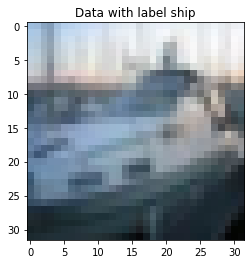

In [24]:
user.plot(true_user_data)

### Reconstruct user data:

In [25]:
attacker.model_template.model.linear[1] = torch.nn.Identity()
attacker.model_template

ConvNetSmall(
  (model): Sequential(
    (conv0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU()
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu2): ReLU()
    (pool0): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu3): ReLU()
    (pool1): AdaptiveAvgPool2d(output_size=1)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Sequential(
      (0): Linear(in_features=1024, out_features=2, bias=True)
      (1): Identity()
      (2): Linear(in_features=2, out_features=1024, bias=True)
      (3): Linear(in_features=1024, out_features=10, bias=True)
    )
  )
)

In [26]:
reconstructed_user_data, stats = attacker.reconstruct(server_payload, shared_data, 
                                                      server.secrets, dryrun=cfg.dryrun)

# How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
                                    server_payload, server.model, user.dataloader, setup=setup,
                                    order_batch=True, compute_full_iip=False)

It: 1. Rec. loss: 0.0867. T: 0.06s
It: 1001. Rec. loss: 0.0057. T: 20.38s
It: 2001. Rec. loss: 0.0061. T: 20.13s
It: 3001. Rec. loss: 0.0046. T: 20.13s
It: 4001. Rec. loss: 0.0065. T: 20.08s
It: 5001. Rec. loss: 0.0062. T: 20.08s
It: 6001. Rec. loss: 0.0053. T: 20.09s
It: 7001. Rec. loss: 0.0052. T: 20.08s
It: 8001. Rec. loss: 0.0051. T: 20.12s
It: 9001. Rec. loss: 0.0045. T: 20.11s
It: 10001. Rec. loss: 0.0029. T: 20.19s
It: 11001. Rec. loss: 0.0029. T: 20.09s
It: 12001. Rec. loss: 0.0029. T: 20.09s
It: 13001. Rec. loss: 0.0030. T: 20.09s
It: 14001. Rec. loss: 0.0028. T: 20.10s
It: 15001. Rec. loss: 0.0028. T: 20.14s
It: 16001. Rec. loss: 0.0026. T: 20.07s
It: 17001. Rec. loss: 0.0026. T: 20.11s
It: 18001. Rec. loss: 0.0027. T: 20.09s
It: 19001. Rec. loss: 0.0027. T: 20.10s
It: 20001. Rec. loss: 0.0027. T: 20.10s
It: 21001. Rec. loss: 0.0027. T: 20.08s
It: 22001. Rec. loss: 0.0027. T: 20.10s
It: 23001. Rec. loss: 0.0026. T: 20.11s
It: 24000. Rec. loss: 0.0027. T: 20.11s
Optimal condid

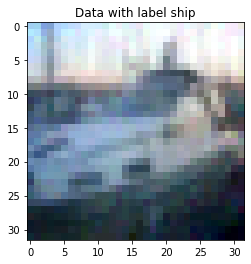

In [27]:
user.plot(reconstructed_user_data, scale=False)

In [28]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
                                    server_payload, server.model, user.dataloader, setup=setup,
                                    order_batch=True, compute_full_iip=True)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/jonas/miniconda3/envs/dl/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
METRICS: | MSE: 0.0014 | PSNR: 28.51 | FMSE: 2.2397e-05 | LPIPS: 0.00| R-PSNR: 28.51 | IIP-pixel: 100.00% | IIP-lpips: 100.00% | IIP-self: 100.00%
